C:\Users\CATALINA ESPINOZA\AppData\Local\conda\conda\envs\env27\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
C:\Users\CATALINA ESPINOZA\AppData\Local\conda\conda\envs\env27\lib\site-packages\nbconvert\exporters\exporter_locator.py:28: DeprecationWarning: `nbconvert.exporters.exporter_locator` is deprecated in favor of `nbconvert.exporters.base` since nbconvert 5.0.
  DeprecationWarning)
C:\Users\CATALINA ESPINOZA\AppData\Local\conda\conda\envs\env27\lib\site-packages\nbconvert\preprocessors\regexremove.py:41: DeprecationWarning: Traits should be given as instances, not types (for example, `Int()`, not `Int`). Passing types is deprecated in traitlets 4.1.
  patterns = List(Unicode, default_value=[r'\Z']).tag(config=True)
C:\Users\CATALINA ESPINOZA\AppData\Local\conda\conda\envs\env27\lib\site-packages\traitlets


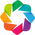

In [2]:
# -*- coding: utf-8 -*-
%matplotlib inline
import os
from ena import text_preprocessing as tp, ena_processing as ep, ena_viz as ev
import numpy as np
from nltk.corpus import stopwords
import matplotlib
import matplotlib.pyplot as plt, mpld3
mpld3.enable_notebook()
import matplotlib.pylab as pylab
import pickle
import pandas as pd
from text_clustering import viz
from sklearn.decomposition import PCA
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
from mpld3 import fig_to_d3

In [3]:
root_path = 'C:\Users\CATALINA ESPINOZA\Documents\clusters ciae'
data_path = os.path.join(root_path,'data')
output_path = os.path.join(root_path,'output')
pickle_path = os.path.join(output_path,'pickles')
by_grade_path = os.path.join(output_path,'textos_ulloa_by_curso')
by_grade_and_content = os.path.join(data_path,'textos_ulloa_by_grade_content')
by_content_path = os.path.join(output_path,'textos_ulloa_by_contenido')
all_files_path = os.path.join(data_path,'textos_ulloa')
all_classes = os.path.join(data_path,'clases_ulloa.txt')

In [5]:
FILTER_BY_LENGTH = True
MIN_LENGTH = 20 # minutes

COPY_WITH_LOSS = False
LOST_WORDS = 10 # percentage

SPLIT_DOCUMENTS_IN_PERIODS = True
PERIOD_LENGTH = 5 # minutss
OVERLAP_LENGTH = 4 # minutes

USE_DIAGONAL = False

## importar trayectorias

In [8]:
with open(os.path.join(pickle_path,str(PERIOD_LENGTH)+'_minutes_'+str(OVERLAP_LENGTH)+'_splitted_stuff.pickle'),'rb') as f:
    splitted_documents = pickle.load(f)
    splitted_labels = pickle.load(f)
    splitted_by_session = pickle.load(f)
    labels_by_session = pickle.load(f)

In [6]:
with open(os.path.join(pickle_path,'super_vectors_'+str(PERIOD_LENGTH)+'_minutes_'+str(OVERLAP_LENGTH)+'overlap_30s_windows_norm_by_stanza.pickle'),'rb') as f:
    super_matrices = pickle.load(f)
    super_vectors = pickle.load(f)
    a_d = pickle.load(f)

In [11]:
all_documents_dict = tp.read_documents(all_files_path)
with open(os.path.join(output_path,'pickles','document_length_dict.pickle'),'rb') as f:
    document_length = pickle.load(f)
if FILTER_BY_LENGTH:
    filtered_documents = tp.filter_by_duration(document_length,all_documents_dict,MIN_LENGTH)
else:
    filtered_documents = all_documents_dict
with open(os.path.join(output_path,'pickles','label_per_audio.pickle'),'rb') as f:
    labels_per_audio = pickle.load(f)
labels_english = pd.read_csv(os.path.join(data_path,'labels_english.csv'),sep=';')
dict_labels_english = {}
for i,k in enumerate(labels_english.key_doc):
    dict_labels_english[str(k)] = labels_english.label_english.values[i]
axes_text = ['Content - Science Skills','Content - Math Skills','Science skills - Math skills']
axes_colors = ['#2fd32f','#D32F2F','#2f2fd3']
levels = [[] for i in range(6)]
counter = 0
for k,v in labels_per_audio.items():
    for i in range(6):
        if k in filtered_documents.keys():
            if v.startswith(str(7+i)):
                levels[i].append(k)
                counter +=1
        levels[i].sort()
        #levels[i] = list()
index_docs = []
for l in levels:
    for l_i in l:
        index_docs.append(l_i)
print len(index_docs)

54


In [59]:
trayectories = {}
for index_doc in range(len(index_docs)):
    doc = index_docs[index_doc]
    n_samples = len(labels_by_session[doc].keys())
    trayectories[doc] = np.empty((n_samples,3))
    for i in range(n_samples):
        # construir label_i
        label_i = doc+'_period_'+str(i)
        #value_i = labels_array_matrices.index(label_i)
        a_label = splitted_labels[label_i]
        trayectories[doc][i][0] = float(round(super_vectors[label_i][0],2)*12)
        trayectories[doc][i][1] = float(round(super_vectors[label_i][1],2)*12)
        trayectories[doc][i][2] = float(round(super_vectors[label_i][2],2)*12)

In [275]:
from dtw import dtw
from numpy.linalg import norm
import matplotlib
import matplotlib.pyplot as plt, mpld3
t_1 = trayectories.values()[0]
t_2 = trayectories['1492699582441']
t_3 = trayectories['1496252136109']
t_4 = trayectories.values()[36]

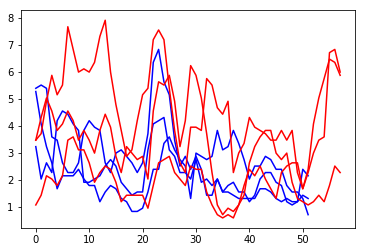

In [61]:
plt.plot(t_1,c='b')
plt.plot(t_2,c='r')

## Clustering using DTW 

In [277]:
dist, cost, acc, path = dtw(t_1, t_2, dist=lambda x, y: norm(x - y, ord=1))
print dist
dist, cost, acc, path = dtw(t_3, t_4, dist=lambda x, y: norm(x - y, ord=1))
dist


1.473846153846154


1.895625

In [63]:
from scipy.cluster import hierarchy

In [129]:
import itertools
dist_condensed_matrix = []
labels_english_list = []
for i in range(len(index_docs)):
    doc1 = index_docs[i]
    labels_english_list.append(dict_labels_english[doc1])
    for j in range(len(index_docs)):
        doc2 = index_docs[j]
        if i<j:
            dist, cost, acc, path = dtw(trayectories[doc1],trayectories[doc2], dist=lambda x, y: norm(x - y,ord=2))
            dist_condensed_matrix.append(dist)

In [135]:
pylab.rcParams['figure.figsize'] = (35,20)

In [225]:
Z = hierarchy.linkage(dist_condensed_matrix,method='ward')

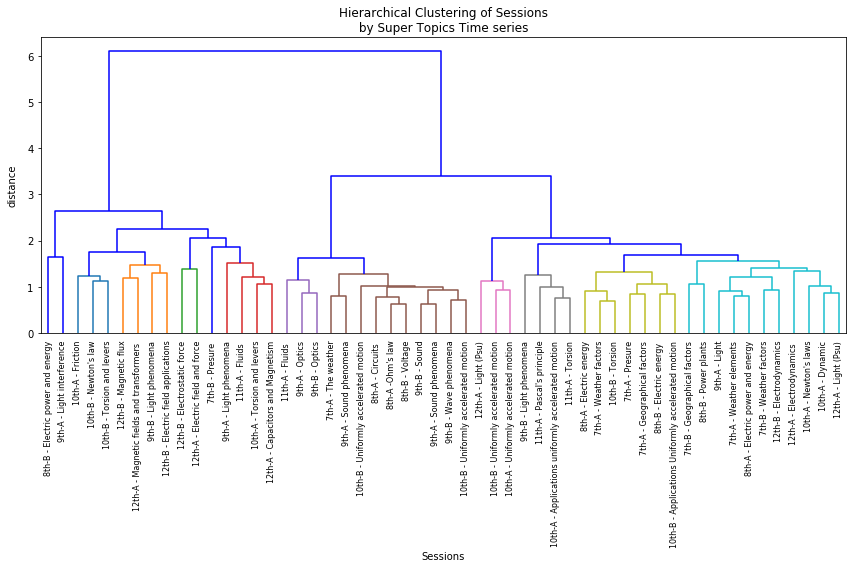

In [226]:
plt.figure(figsize=(12, 8))
dn = hierarchy.dendrogram(Z,
                         leaf_rotation=90.,  # rotates the x axis labels
                          leaf_font_size=8.,  # font size for the x axis labels
                          labels=labels_english_list,
                         color_threshold=1.6)
plt.title('Hierarchical Clustering of Sessions\n by Super Topics Time series ')
plt.xlabel('Sessions')
plt.ylabel('distance',labelpad=10)
plt.tight_layout()
plt.savefig("foo.pdf")


### Trajectories with all the components

In [164]:
with open(os.path.join(pickle_path,'co_occurrence_matrices'+str(PERIOD_LENGTH)+'_minutes_'+str(OVERLAP_LENGTH)+'overlap_complete_sample.pickle'),'rb') as f:
    co_ocurrence_matrices = pickle.load(f)
    labels_array_matrices = pickle.load(f)
    co_ocurrence_matrices_all_corpus = pickle.load(f)
    labels_corpus = pickle.load(f)

norm_matrices = {}
for key in co_ocurrence_matrices.keys():
    norm_matrices[key] = co_ocurrence_matrices[key]*12.0/ep.get_n_stanzas_by_doc(PERIOD_LENGTH*60/5,6,1)

In [171]:
norm_vectors = {}
for j in range(len(index_docs)):
    doc = index_docs[j]
    norm_vectors[doc] = []
    for i in range(len(labels_by_session[doc].keys())):
        # construir label_i
        label_i =  doc+'_period_'+str(i)
        a_matrix = norm_matrices[label_i]
        aux_vector = []
        for k in range(len(a_matrix)):
            for h in range(len(a_matrix)):
                if k < h:
                    aux_vector.append(a_matrix[k,h])
        norm_vectors[doc].append(aux_vector)

In [283]:
dict_labels_english[norm_vectors.keys()[0]]
dict_labels_english['1492699582441']
norm_vectors.keys()[0]

u'1493908207910'

In [284]:
t_1 = norm_vectors.values()[0]
t_2 = norm_vectors['1492699582441']
t_3 = norm_vectors['1496252136109']
t_4 = norm_vectors.values()[36]
dist, cost, acc, path = dtw(np.array(t_1), np.array(t_2), dist=lambda x, y: norm(x - y, ord=2))
print dist
dist, cost, acc, path = dtw(np.array(t_3), np.array(t_4), dist=lambda x, y: norm(x - y, ord=2))
dist

0.8267547913304397


1.1123217933623646

In [176]:
dist_condensed_matrix_2 = []
labels_english_list = []
for i in range(len(index_docs)):
    doc1 = index_docs[i]
    labels_english_list.append(dict_labels_english[doc1])
    for j in range(len(index_docs)):
        doc2 = index_docs[j]
        if i<j:
            dist, cost, acc, path = dtw(np.array(norm_vectors[doc1]),np.array(norm_vectors[doc2]), dist=lambda x, y: norm(x - y,ord=2))
            dist_condensed_matrix_2.append(dist)

In [227]:
Z = hierarchy.linkage(dist_condensed_matrix_2,method='ward')

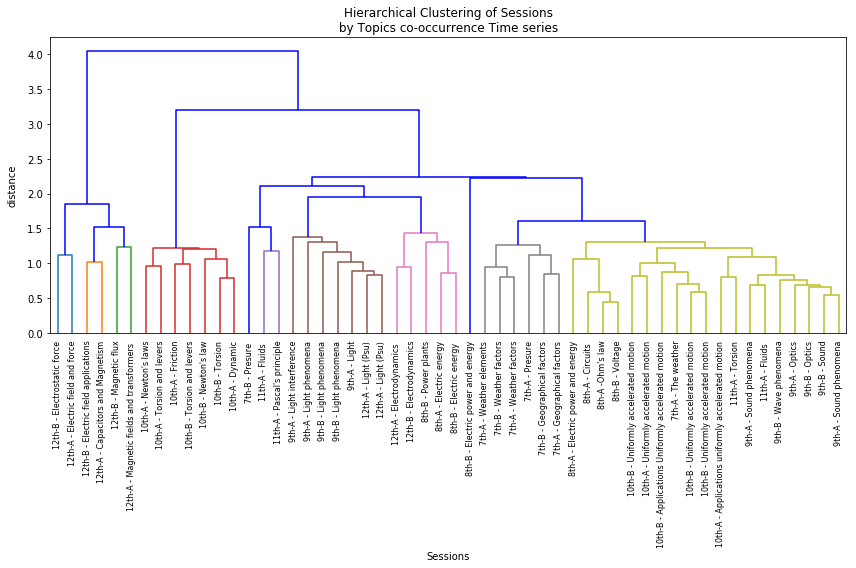

In [228]:
plt.figure(figsize=(12, 8))
hierarchy.set_link_color_palette(palette)
dn = hierarchy.dendrogram(Z,
                         leaf_rotation=90.,  # rotates the x axis labels
                          leaf_font_size=8.,  # font size for the x axis labels
                          labels=labels_english_list,
                          color_threshold=1.5
                         )
plt.title('Hierarchical Clustering of Sessions\n by Topics co-occurrence Time series ')
plt.xlabel('Sessions')
plt.ylabel('distance',labelpad=10)
plt.tight_layout()
#plt.savefig('foo2.png')
plt.savefig("foo2.pdf")


In [204]:
import random
def rgb2hex(color):
    string = '#'
    for value in color:
        hex_string = hex(value)  #  e.g. 0x7f
        reduced_hex_string = hex_string[2:]  # e.g. 7f
        capitalized_hex_string = reduced_hex_string.upper()  # e.g. 7F
        string += capitalized_hex_string  # e.g. #7F7F7F
    return string

def colors(n):
    ret = []
    r = int(random.random() * 256)
    g = int(random.random() * 256)
    b = int(random.random() * 256)
    step = 256 / n
    for i in range(n):
        r += step
        g += step
        b += step
        r = int(r) % 256
        g = int(g) % 256
        b = int(b) % 256
        ret.append(rgb2hex((r,g,b)) )
    return ret
import seaborn as sns
palette = sns.color_palette(None, 10)

In [220]:
import seaborn as sns
palette = sns.color_palette(None, 10)
palette = map(lambda x: matplotlib.colors.to_hex(x),palette)